In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import math as m
import sympy as smp
from IPython.display import display as disp
import lablib as ll
%matplotlib inline

In [2]:
data = {}
work = {}

kinds = ["heating", "cooling"]
colors = {
    "heating": "#800000",
    "cooling": "#000080"
}

constants = ll.read_csv("constants.csv")

for kind in kinds:
    data[kind] = ll.read_csv("measurements/%s.csv" % kind)
    work[kind] = ll.varlist()
    ll.add(work[kind],
           constants)

for kind in kinds:
    disp("Data for kind %s" % kind, data[kind])

for kind in kinds:
    disp("Working variables for kind %s" % kind, work[kind])

'Data for kind heating'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h
0,299.150000,0.050000,0.02%,0.106000,0.073900,0.174750,0.000500
1,300.150000,0.050000,0.02%,0.106800,0.073450,0.174200,0.000500
2,301.150000,0.050000,0.02%,0.107550,0.072700,0.173600,0.000500
3,302.150000,0.050000,0.02%,0.108300,0.072000,0.172800,0.000500
4,303.150000,0.050000,0.02%,0.109300,0.071000,0.172100,0.000500
5,304.150000,0.050000,0.02%,0.110300,0.070200,0.171100,0.000500
6,305.150000,0.050000,0.02%,0.111200,0.069200,0.170400,0.000500
7,306.150000,0.050000,0.02%,0.112200,0.068400,0.169200,0.000500
8,307.150000,0.050000,0.02%,0.113200,0.067400,0.168000,0.000500
9,308.150000,0.050000,0.02%,0.114350,0.066300,0.166900,0.000500


'Data for kind cooling'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h
0,309.150000,0.050000,0.02%,0.115000,0.064400,0.164400,0.000500
1,307.150000,0.050000,0.02%,0.112700,0.066700,0.166400,0.000500
2,305.150000,0.050000,0.02%,0.110700,0.068600,0.168000,0.000500
3,303.150000,0.050000,0.02%,0.108600,0.070400,0.169700,0.000500


'Working variables for kind heating'

,Value,Error,ErrorRel
T_boil,373.000000,0.500000,0.13%
d_hg_20,13546.000000,0.500000,0.00%
d_hg_40,13497.000000,0.500000,0.00%
d_h2o_20,998.200000,0.050000,0.01%
d_h2o_40,992.200000,0.050000,0.01%
g,9.820300,0.000050,0.00%
R,8.314460,0.000000,0.00%


'Working variables for kind cooling'

,Value,Error,ErrorRel
T_boil,373.000000,0.500000,0.13%
d_hg_20,13546.000000,0.500000,0.00%
d_hg_40,13497.000000,0.500000,0.00%
d_h2o_20,998.200000,0.050000,0.01%
d_h2o_40,992.200000,0.050000,0.01%
g,9.820300,0.000050,0.00%
R,8.314460,0.000000,0.00%


In [3]:
#
# density = (density_40 - density_20)/20 * T + (density_20 - 293.15/20 * (density_40 - density_20))
#

# we will account for changing densities of liquids inside of the mercury barometer
def model_density(T, d_40, d_20):
    return ((d_40 - d_20) / 20) * T + (d_20 - 293.15/20 * (d_40 - d_20))

# this function calculates pressure at given temperature and given barometer readings
# we pass constants as arguments because we would like to calculate the error accounting uncertainties of all
# participating data, including reference point densities and the gravitational acceleration
def model_pressure(h_upper, h_lower, h_lower_condensate, T, d_hg_40, d_hg_20, d_h2o_40, d_h2o_20, g):
    # density_hg * g * h
    # density_hg * g * (h_upper - h_lower)
    # density_hg * g * h_upper - density_hg * g * h_lower - density_h2o * g * h_condensate
    # g * (density_hg * (h_upper - h_lower) - density_h2o * h_condensate)
    density_hg = model_density(T, d_hg_40, d_hg_20)
    density_h2o = model_density(T, d_h2o_40, d_h2o_20)
    return g * (density_hg * (h_upper - h_lower) - density_h2o * (h_lower_condensate - h_lower))

sym_h_u, sym_h_l, sym_h_l_c, sym_T, sym_d_hg_40, sym_d_hg_20, sym_d_h2o_40, sym_d_h2o_20, sym_g = \
    smp.symbols("h_upper h_lower h_lower_condensate T d_hg_40 d_hg_20 d_h2o_40 d_h2o_20 g")

sym_pressure = model_pressure(h_upper = sym_h_u,
                              h_lower = sym_h_l,
                              h_lower_condensate = sym_h_l_c,
                              T = sym_T,
                              d_hg_40 = sym_d_hg_40,
                              d_hg_20 = sym_d_hg_20,
                              d_h2o_40 = sym_d_h2o_40,
                              d_h2o_20 = sym_d_h2o_20,
                              g = sym_g)

sym_pressure_cols_mapping = {
    "h_upper": {
        "Value": "h_upper",
        "Error": "Error_h"
    },
    "h_lower": {
        "Value": "h_lower",
        "Error": "Error_h"
    },
    "h_lower_condensate": {
        "Value": "h_lower_condensate",
        "Error": "Error_h"
    },
    "T": {
        "Value": "T",
        "Error": "Error_T"
    }
}

for kind in kinds:
    data[kind]["P"], data[kind]["Error_P"] = ll.sym_compute_column("pressure",
                                                                   sym_pressure,
                                                                   work[kind],
                                                                   sym_pressure_cols_mapping,
                                                                   data[kind])
    disp("Data for %s:" % kind, data[kind])

Error influence estimations for pressure:


,Error,Derivative,(E*D)^2
T,None,21.1136450000005*h_lower + 2.94608999999997*h_...,96.43829209*Error_T**2*(2.15000000000005*h_low...
d_h2o_20,0.050000,-9.8203*(-T/20 + 15.6575)*(-h_lower + h_lower_...,0.241095730225*(-T/20 + 15.6575)**2*(-h_lower ...
d_h2o_40,0.050000,-9.8203*(T/20 - 14.6575)*(-h_lower + h_lower_c...,0.241095730225*(T/20 - 14.6575)**2*(-h_lower +...
d_hg_20,0.500000,9.8203*(-T/20 + 15.6575)*(-h_lower + h_upper),24.1095730225*(-T/20 + 15.6575)**2*(-h_lower +...
d_hg_40,0.500000,9.8203*(T/20 - 14.6575)*(-h_lower + h_upper),24.1095730225*(T/20 - 14.6575)**2*(-h_lower + ...
g,0.000050,(-2.45000000000005*T + 14264.2175)*(-h_lower +...,2.5e-9*((-2.45000000000005*T + 14264.2175)*(-h...
h_lower,None,21.1136450000005*T - 129412.62537175,96.43829209*Error_h_lower**2*(2.15000000000005...
h_lower_condensate,None,2.94608999999997*T - 10666.2697435,96.43829209*Error_h_lower_condensate**2*(0.299...
h_upper,None,-24.0597350000004*T + 140078.89511525,96.43829209*Error_h_upper**2*(-2.4500000000000...


'Data for heating:'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P
0,299.150000,0.050000,0.02%,0.106000,0.073900,0.174750,0.000500,3278.681858,90.700094
1,300.150000,0.050000,0.02%,0.106800,0.073450,0.174200,0.000500,3445.256561,90.684040
2,301.150000,0.050000,0.02%,0.107550,0.072700,0.173600,0.000500,3642.534088,90.667988
3,302.150000,0.050000,0.02%,0.108300,0.072000,0.172800,0.000500,3835.543885,90.651937
4,303.150000,0.050000,0.02%,0.109300,0.071000,0.172100,0.000500,4097.605906,90.635892
5,304.150000,0.050000,0.02%,0.110300,0.070200,0.171100,0.000500,4337.906339,90.619848
6,305.150000,0.050000,0.02%,0.111200,0.069200,0.170400,0.000500,4586.509051,90.603808
7,306.150000,0.050000,0.02%,0.112200,0.068400,0.169200,0.000500,4828.585829,90.587771
8,307.150000,0.050000,0.02%,0.113200,0.067400,0.168000,0.000500,5095.159149,90.571741
9,308.150000,0.050000,0.02%,0.114350,0.066300,0.166900,0.000500,5392.849587,90.555718


Error influence estimations for pressure:


,Error,Derivative,(E*D)^2
T,None,21.1136450000005*h_lower + 2.94608999999997*h_...,96.43829209*Error_T**2*(2.15000000000005*h_low...
d_h2o_20,0.050000,-9.8203*(-T/20 + 15.6575)*(-h_lower + h_lower_...,0.241095730225*(-T/20 + 15.6575)**2*(-h_lower ...
d_h2o_40,0.050000,-9.8203*(T/20 - 14.6575)*(-h_lower + h_lower_c...,0.241095730225*(T/20 - 14.6575)**2*(-h_lower +...
d_hg_20,0.500000,9.8203*(-T/20 + 15.6575)*(-h_lower + h_upper),24.1095730225*(-T/20 + 15.6575)**2*(-h_lower +...
d_hg_40,0.500000,9.8203*(T/20 - 14.6575)*(-h_lower + h_upper),24.1095730225*(T/20 - 14.6575)**2*(-h_lower + ...
g,0.000050,(-2.45000000000005*T + 14264.2175)*(-h_lower +...,2.5e-9*((-2.45000000000005*T + 14264.2175)*(-h...
h_lower,None,21.1136450000005*T - 129412.62537175,96.43829209*Error_h_lower**2*(2.15000000000005...
h_lower_condensate,None,2.94608999999997*T - 10666.2697435,96.43829209*Error_h_lower_condensate**2*(0.299...
h_upper,None,-24.0597350000004*T + 140078.89511525,96.43829209*Error_h_upper**2*(-2.4500000000000...


'Data for cooling:'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P
0,309.150000,0.050000,0.02%,0.115000,0.064400,0.164400,0.000500,5736.077297,90.539705
1,307.150000,0.050000,0.02%,0.112700,0.066700,0.166400,0.000500,5130.482179,90.571742
2,305.150000,0.050000,0.02%,0.110700,0.068600,0.168000,0.000500,4617.363844,90.603809
3,303.150000,0.050000,0.02%,0.108600,0.070400,0.169700,0.000500,4101.919080,90.635891


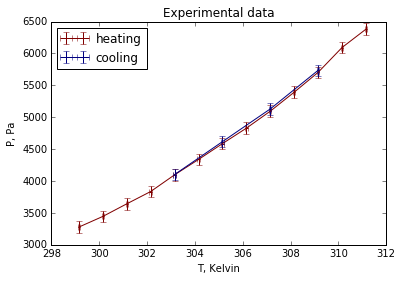

In [4]:
plt.title("Experimental data")
plt.ylabel("P, Pa")
plt.xlabel("T, Kelvin")

for kind in kinds:
    plt.errorbar(x = data[kind]["T"], y = data[kind]["P"],
                 xerr = data[kind]["Error_T"], yerr = data[kind]["Error_P"],
                 label = kind, color = colors[kind])

plt.legend(loc = "best")

In [5]:
def model_lnP(P):
    return smp.log(P)

def model_invT(T):
    return 1/T

sym_P, sym_T = smp.symbols("P T")

sym_lnP = model_lnP(sym_P)
sym_invT = model_invT(sym_T)

sym_lnP_cols_mapping = {
    "P": {
        "Value": "P",
        "Error": "Error_P"
    }
}

sym_invT_cols_mapping = {
    "T": {
        "Value": "T",
        "Error": "Error_T"
    }
}

for kind in kinds:
    data[kind]["lnP"], data[kind]["Error_lnP"] = ll.sym_compute_column("pressure logarithm",
                                                                       sym_lnP,
                                                                       work[kind],
                                                                       sym_lnP_cols_mapping,
                                                                       data[kind])
    data[kind]["invT"], data[kind]["Error_invT"] = ll.sym_compute_column("inverse absolute temp",
                                                                       sym_invT,
                                                                       work[kind],
                                                                       sym_invT_cols_mapping,
                                                                       data[kind])
    disp("Calculated data for %s:" % kind, data[kind])

Error influence estimations for pressure logarithm:


,Error,Derivative,(E*D)^2
P,None,1/P,Error_P**2/P**2


Error influence estimations for inverse absolute temp:


,Error,Derivative,(E*D)^2
T,None,-1/T**2,Error_T**2/T**4


'Calculated data for heating:'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P,lnP,Error_lnP,invT,Error_invT
0,299.150000,0.050000,0.02%,0.106000,0.073900,0.174750,0.000500,3278.681858,90.700094,8.095197,0.027664,0.003343,0.000001
1,300.150000,0.050000,0.02%,0.106800,0.073450,0.174200,0.000500,3445.256561,90.684040,8.144754,0.026321,0.003332,0.000001
2,301.150000,0.050000,0.02%,0.107550,0.072700,0.173600,0.000500,3642.534088,90.667988,8.200435,0.024891,0.003321,0.000001
3,302.150000,0.050000,0.02%,0.108300,0.072000,0.172800,0.000500,3835.543885,90.651937,8.252067,0.023635,0.003310,0.000001
4,303.150000,0.050000,0.02%,0.109300,0.071000,0.172100,0.000500,4097.605906,90.635892,8.318158,0.022119,0.003299,0.000001
5,304.150000,0.050000,0.02%,0.110300,0.070200,0.171100,0.000500,4337.906339,90.619848,8.375147,0.020890,0.003288,0.000001
6,305.150000,0.050000,0.02%,0.111200,0.069200,0.170400,0.000500,4586.509051,90.603808,8.430874,0.019754,0.003277,0.000001
7,306.150000,0.050000,0.02%,0.112200,0.068400,0.169200,0.000500,4828.585829,90.587771,8.482309,0.018761,0.003266,0.000001
8,307.150000,0.050000,0.02%,0.113200,0.067400,0.168000,0.000500,5095.159149,90.571741,8.536046,0.017776,0.003256,0.000001
9,308.150000,0.050000,0.02%,0.114350,0.066300,0.166900,0.000500,5392.849587,90.555718,8.592829,0.016792,0.003245,0.000001


Error influence estimations for pressure logarithm:


,Error,Derivative,(E*D)^2
P,None,1/P,Error_P**2/P**2


Error influence estimations for inverse absolute temp:


,Error,Derivative,(E*D)^2
T,None,-1/T**2,Error_T**2/T**4


'Calculated data for cooling:'

,T,Error_T,ErrorRel_T,h_upper,h_lower,h_lower_condensate,Error_h,P,Error_P,lnP,Error_lnP,invT,Error_invT
0,309.150000,0.050000,0.02%,0.115000,0.064400,0.164400,0.000500,5736.077297,90.539705,8.654531,0.015784,0.003235,0.000001
1,307.150000,0.050000,0.02%,0.112700,0.066700,0.166400,0.000500,5130.482179,90.571742,8.542955,0.017654,0.003256,0.000001
2,305.150000,0.050000,0.02%,0.110700,0.068600,0.168000,0.000500,4617.363844,90.603809,8.437579,0.019622,0.003277,0.000001
3,303.150000,0.050000,0.02%,0.108600,0.070400,0.169700,0.000500,4101.919080,90.635891,8.319210,0.022096,0.003299,0.000001


Initial guesses for heating:
                   Value      Error  ErrorRel
dlnP_dinvT -5242.665500 138.546088 -0.026427
b             25.610182   0.451865  0.017644


'Final guesses for heating:'

,Value,Error,ErrorRel
dlnP_dinvT,-5242.309539,36.933459,-0.70%
b,25.609017,0.120468,0.47%


Initial guesses for cooling:
                   Value      Error  ErrorRel
dlnP_dinvT -5200.711011 393.717202 -0.075704
b             25.476966   1.283826  0.050392


'Final guesses for cooling:'

,Value,Error,ErrorRel
dlnP_dinvT,-5200.837742,66.750449,-1.28%
b,25.477379,0.217666,0.85%


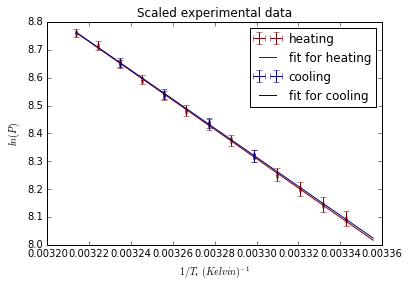

In [6]:
def fit_model(x, a, b):
    return a * x + b
fit_model_args = ["dlnP_dinvT", "b"]

for kind in kinds:
    ll.add(work[kind], ll.fit(name = kind,
                              model = fit_model,
                              model_args = fit_model_args,
                              x = data[kind]["invT"],
                              y = data[kind]["lnP"],
                              xerr = data[kind]["Error_invT"],
                              yerr = data[kind]["Error_lnP"]))
    
plt.title("Scaled experimental data")
plt.ylabel("$ln(P)$")
plt.xlabel("$1/T$, $(Kelvin)^{-1}$")

x_linspace = ll.linspace([x for x in data["heating"]["invT"]])

for kind in kinds:
    plt.errorbar(x = data[kind]["invT"], y = data[kind]["lnP"],
                 xerr = data[kind]["Error_invT"], yerr = data[kind]["Error_lnP"],
                 ls = 'none', label = kind, color = colors[kind])
    plt.errorbar(x = x_linspace, y = fit_model(x_linspace, *work[kind].Value[fit_model_args]),
                 label = "fit for %s" % kind, color = colors[kind])

plt.legend(loc = "best")

In [7]:
def model_Qev(R, dlnP_dinvT):
    return -R * dlnP_dinvT

sym_R, sym_dlnP_dinvT = smp.symbols("R dlnP_dinvT")
sym_Qev = model_Qev(sym_R, sym_dlnP_dinvT)

for kind in kinds:
    ll.add(work[kind], ll.sym_compute("Qev", sym_Qev, work[kind]))
    disp("Q_ev for %s:" % kind, work[kind].loc[["Qev"]])

Error influence estimations for Qev:


,Error,Derivative,(E*D)^2
dlnP_dinvT,36.933459,-8.31445980000000,94299.2066516492
R,0.000000,5242.30953905985,6.87045232582948e-8


'Q_ev for heating:'

,Value,Error,ErrorRel
Qev,43586.971922,307.081759,0.007045


Error influence estimations for Qev:


,Error,Derivative,(E*D)^2
dlnP_dinvT,66.750449,-8.31445980000000,308018.256535240
R,0.000000,5200.83774155266,6.76217830348965e-8


'Q_ev for cooling:'

,Value,Error,ErrorRel
Qev,43242.156328,554.993925,0.012835


Теплота испарения:
- при нагреве: $Q = 43500 \pm 300 \frac{Дж}{моль}$
- при охлаждении: $Q = 43200 \pm 500 \frac{Дж}{моль}$